In [291]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## Making SPI value data

In [292]:
#football.co.uk data from seasons 2005-2021
df3 = pd.read_csv('MASTER NEW MERGED.csv', parse_dates=['Date'], dayfirst=True)

In [293]:
#Arthur Caldlas data
df2 = pd.read_csv('all_matches.csv', parse_dates=['date'], dayfirst=True)
df2.rename(columns={'date': 'Date', 'home_team': 'HomeTeam', 'away_team': 'AwayTeam'}, inplace=True)

# replacing newly promoted sides last season rank to 20
df2['ht_ls_rank'].fillna(20, inplace=True)
df2['at_ls_rank'].fillna(20, inplace=True)

In [294]:
#following are the average values of (spi/position) of teams in league position 1-20 from 2016-2021
multipliers = [84.32666666666667,84.32666666666667,43.41030303030303,28.288080808080814,21.040568181818188,
               16.396046511627908,13.34537037037037,9.479970238095241,8.404602272727272,7.40640826873385,6.082409090909092,
               5.875535353535356,5.339311594202898,4.795091575091576,4.421413043478262,3.7990387596899224,
               3.693252840909091,3.57659090909091,3.0161527777777786,2.992295632698769,2.745684782608696,2.745684782608696]

#converting float current and  last season's positions to integer
h_last_s_ranks = [int(x) for x in list(df2['ht_ls_rank'])]
a_last_s_ranks = [int(x) for x in list(df2['at_ls_rank'])]
h_curr_s_ranks = [int(x) for x in list(df2['ht_rank'])]
a_curr_s_ranks = [int(x) for x in list(df2['at_rank'])]

#creating column containing multiplier values according to current and previous league positions
df2['spi1_last'] =  [multipliers[x] for x in h_last_s_ranks]
df2['spi2_last'] =  [multipliers[x] for x in a_last_s_ranks]

df2['spi1_curr'] =  [multipliers[x] for x in h_curr_s_ranks]
df2['spi2_curr'] =  [multipliers[x] for x in a_curr_s_ranks]

In [295]:
#inner joining the 2 csv files
merged_df = df3.merge(df2, how='inner', left_on=["Date", "HomeTeam", "AwayTeam"], right_on=["Date", "HomeTeam", "AwayTeam"])
merged_df.shape

(6077, 84)

In [296]:
#spi value data for each match from 2016 onwards (some matches missing)
df_spi = pd.read_csv('spi_matches_1.csv', parse_dates=['date'])
df_spi.rename(columns={'date': 'Date', 'team1': 'HomeTeam', 'team2': 'AwayTeam','spi1':'spi1_', 'spi2':'spi2_'}, inplace=True)
df_spi.shape

(2277, 23)

In [297]:
#joined spi info csv with the above merged data
merged_df1 = merged_df.merge(df_spi, how='left')

#removed columns which are too few, although important
merged_df1.drop(['importance1','importance2','score1','score2','xg1','xg2',
                 'nsxg1','nsxg2','adj_score1','adj_score2','league_id','league',
                 'prob1','prob2','probtie','proj_score1','proj_score2'],axis=1, inplace=True)

#2 columns added, spi for home and away team
merged_df1.shape

(6077, 86)

In [298]:
#for locations 3797:5696 spi values are available, so simply populating
merged_df1.loc[3797:5696, 'spi1'] = merged_df1['spi1_']
merged_df1.loc[3797:5696, 'spi2'] = merged_df1['spi2_']

#removing the temp column made previously
merged_df1.drop(['spi1_','spi2_'],axis=1, inplace=True)

In [299]:
# custom formula made to populate empty spi values
# 20% priority given to position of last season, 80% priority given to current position
# formula: spi = (0.2 x last_position x avg_spi_for_that_position) + (0.8 x current_position x avg_spi_for_that_position)
# avg_spi_for_that_position provided by the multiplier list
merged_df1.loc[merged_df1['spi1'].isnull(),'spi1'] = merged_df1['ht_ls_rank']*merged_df1['spi1_last']*0.2 + merged_df1['ht_rank']*merged_df1['spi1_curr'] *0.8
merged_df1.loc[merged_df1['spi2'].isnull(), 'spi2'] = merged_df1['at_ls_rank']*merged_df1['spi2_last']*0.2 + merged_df1['at_rank']*merged_df1['spi2_curr'] *0.8
merged_df1.drop(['spi1_last','spi2_last','spi1_curr','spi2_curr'],axis=1, inplace=True)

In [300]:
#output as csv file
temp = merged_df1.rename(columns={"FTR_x":"FTR", "HTR_x":"HTR"})
temp.to_csv('finalData/merged_spi_all.csv')

## Preparing final data

In [407]:
from sklearn.preprocessing import LabelEncoder

#using the above created csv file
df_new_2021 = pd.read_csv('finalData/merged_spi_all.csv', parse_dates=['Date'])

#converting H=2, D=1, A=0
df_new_2021['FTR'] = LabelEncoder().fit_transform(df_new_2021['FTR'])
df_new_2021['HTR'] = LabelEncoder().fit_transform(df_new_2021['HTR'])

In [408]:
#find streak [home win = 2, draw = 1, away win=0]
#returns 3 for win, 1 for draw and 0 for loss
def streak(away, result):
    draw = result==1
    loss = (away and result==2) or (not away and result==0)
    win = (away and result==0) or (not away and result==2)
    if draw:
        return 1
    elif loss:
        return 0
    elif win:
        return 3

In [409]:
#returns the row indices for given club in the dataframe
def getClubIndex(clubName, df_given):
    df_club = df_given[(df_given[['HomeTeam','AwayTeam']].values == [clubName, clubName])]
    df_club = df_club.sort_values(by=['Date'])
    club_rows = {}
    i = 0
    for index, row in df_club.iterrows():
        club_rows[i] = index
        i+=1
    return club_rows

In [410]:
#returns the aggregate count of various features (goals, shots, etc.) of each club in the last "x" no. of games
#for data of games less than the "x" count, treated separately
def populateGamesData(club_rows, homeHeader, awayHeader, newHomeHeader, newAwayHeader, clubName, gamesCount, df_given):
    for key in club_rows:

        if key==(32-gamesCount):
            break

        aways = [0] * (gamesCount+1)
        venues = [0] * (gamesCount+1)
        val = 0
        for a in range(gamesCount):
            #home or away?
            aways[a] = df_given.loc[club_rows[key+a], 'AwayTeam'] == clubName
            #venue
            venues[a] = (homeHeader, awayHeader)[aways[a]]
            #value to be populated
            val += df_given.loc[club_rows[key+a], venues[a]]
        aways[gamesCount] = df_given.loc[club_rows[key+gamesCount], 'AwayTeam'] == clubName
        current_loc = (newHomeHeader,newAwayHeader)[aways[gamesCount]]
        df_given.loc[club_rows[key+gamesCount], current_loc] = val
        
        #for first "gamesCount" rows:
        if key in range(1,gamesCount):
            val = 0
            for b in range(key):
                #home or away?
                aways[b] = df_given.loc[club_rows[b], 'AwayTeam'] == clubName
                #venue
                venues[b] = (homeHeader, awayHeader)[aways[b]]
                #value to be populated
                val += df_given.loc[club_rows[b], venues[b]]
            aways[key] = df_given.loc[club_rows[key], 'AwayTeam'] == clubName
            current_loc = (newHomeHeader,newAwayHeader)[aways[key]]
            df_given.loc[club_rows[key], current_loc] = val

In [411]:
#returns total, average, "spi"-ed total, "spi"-ed average points for last "x" no. of games for each club
#custom formula used to calculate "spi"-ed total points
#formula: (match_points * spi_of_opposition)/100
#for data of games less than the "x" count, treated separately
def populateWinStreak(clubName, club_rows, gamesCount, df_given):
    for key in club_rows:
        if key==(31-gamesCount):
            break
                
        aways = [0] * (gamesCount+1)
        
        result_full = [0] * (gamesCount+1)
        result_half = [0] * (gamesCount+1)
        result_full_spi = [0] * (gamesCount+1)
        result_half_spi = [0] * (gamesCount+1)
        
        val_full = 0
        val_half = 0
        val_full_spi = 0
        val_half_spi = 0

        for a in range(gamesCount):
            #home or away?
            aways[a] = df_given.loc[club_rows[key+a], 'AwayTeam'] == clubName
            
            #ftr
            result_full[a] = streak(aways[a], df_given.loc[club_rows[key+a],'FTR'])
            result_full_spi[a] = (result_full[a]/100)*(df_given.loc[club_rows[key+a],'spi1'],df_given.loc[club_rows[key+a],'spi2'])[not aways[a]]
            
            #htr
            result_half[a] = streak(aways[a], df_given.loc[club_rows[key+a],'HTR'])
            result_half_spi[a] = (result_half[a]/100)*(df_given.loc[club_rows[key+a],'spi1'],df_given.loc[club_rows[key+a],'spi2'])[not aways[a]]

            #value full time to be populated
            val_full += result_full[a]
            val_full_spi += result_full_spi[a]
            
            #value half time to be populated
            val_half += result_half[a]
            val_half_spi += result_half_spi[a]
           
        aways[gamesCount] = df_given.loc[club_rows[key+gamesCount], 'AwayTeam'] == clubName
        current_loc = ("L"+str(gamesCount)+"G-"+'HWS-F',"L"+str(gamesCount)+"G-"+'AWS-F')[aways[gamesCount]]
        df_given.loc[club_rows[key+gamesCount], current_loc] = val_full
        df_given.loc[club_rows[key+gamesCount], current_loc+'A'] = val_full/gamesCount
        df_given.loc[club_rows[key+gamesCount], current_loc+'-SPI'] = val_full_spi
        df_given.loc[club_rows[key+gamesCount], current_loc+'-SPIA'] = val_full_spi/gamesCount
        
        current_loc = ("L"+str(gamesCount)+"G-"+'HWS-H',"L"+str(gamesCount)+"G-"+'AWS-H')[aways[gamesCount]]
        df_given.loc[club_rows[key+gamesCount], current_loc] = val_half
        df_given.loc[club_rows[key+gamesCount], current_loc+'A'] = val_half/gamesCount
        df_given.loc[club_rows[key+gamesCount], current_loc+'-SPI'] = val_half_spi
        df_given.loc[club_rows[key+gamesCount], current_loc+'-SPIA'] = val_half_spi/gamesCount
        
        #for first "gamesCount" rows:
        if key in range(1,gamesCount):
            val_full = 0
            val_half = 0
            val_full_spi = 0
            val_half_spi = 0
            for a in range(key):
                #home or away?
                aways[a] = df_given.loc[club_rows[a], 'AwayTeam'] == clubName
                #ftr
                result_full[a] = streak(aways[a], df_given.loc[club_rows[a],'FTR'])
                result_full_spi[a] = (result_full[a]/100)*(df_given.loc[club_rows[a],'spi1'],df_given.loc[club_rows[a],'spi2'])[not aways[a]]

                #htr
                result_half[a] = streak(aways[a], df_given.loc[club_rows[a],'HTR'])
                result_half_spi[a] = (result_half[a]/100)*(df_given.loc[club_rows[a],'spi1'],df_given.loc[club_rows[a],'spi2'])[not aways[a]]

                #value full time to be populated
                val_full += result_full[a]
                val_full_spi += result_full_spi[a]
                
                #value half time to be populated
                val_half += result_half[a]
                val_half_spi += result_half_spi[a]
                
            aways[key] = df_given.loc[club_rows[key], 'AwayTeam'] == clubName
            current_loc = ("L"+str(gamesCount)+"G-"+'HWS-F',"L"+str(gamesCount)+"G-"+'AWS-F')[aways[key]]
            df_given.loc[club_rows[key], current_loc] = val_full
            df_given.loc[club_rows[key], current_loc+'A'] = val_full/gamesCount
            df_given.loc[club_rows[key], current_loc+'-SPI'] = val_full_spi
            df_given.loc[club_rows[key], current_loc+'-SPIA'] = val_full_spi/gamesCount

            current_loc = ("L"+str(gamesCount)+"G-"+'HWS-H',"L"+str(gamesCount)+"G-"+'AWS-H')[aways[key]]
            df_given.loc[club_rows[key], current_loc] = val_half
            df_given.loc[club_rows[key], current_loc+'A'] = val_half/gamesCount
            df_given.loc[club_rows[key], current_loc+'-SPI'] = val_half_spi
            df_given.loc[club_rows[key], current_loc+'-SPIA'] = val_half_spi/gamesCount

In [412]:
#returns aggregate count of goals of each club in the last "x" no. of games
#done separately to accomodate home teams' and away teams' goals scored and conceded
#for data of games less than the "x" count, treated separately
def populateGoalsForAndAgainst(club_rows, homeHeader, awayHeader, clubName, gamesCount, df_given):
    for key in club_rows:

        if key==(31-gamesCount):
            break
                
        aways = [0] * (gamesCount+1)
        venues = [0] * (gamesCount+1)
        val = 0

        for a in range(gamesCount):
            #home or away?
            aways[a] = df_given.loc[club_rows[key+a], 'AwayTeam'] == clubName
            #venue
            venues[a] = (homeHeader, awayHeader)[aways[a]]
            #value to be populated
            val += df_given.loc[club_rows[key+a], venues[a]]
        
        aways[gamesCount] = df_given.loc[club_rows[key+gamesCount], 'AwayTeam'] == clubName        
        current_loc = ("L"+str(gamesCount)+"G-"+homeHeader+'-F',"L"+str(gamesCount)+"G-"+awayHeader+'-F')[aways[gamesCount]]
        df_given.loc[club_rows[key+gamesCount], current_loc] = val
        
        val = 0
        for b in range(gamesCount):
            #home or away?
            aways[b] = df_given.loc[club_rows[key+b], 'AwayTeam'] == clubName
            #venue
            venues[b] = (homeHeader, awayHeader)[not aways[b]]
            #value to be populated
            val += df_given.loc[club_rows[key+b], venues[b]]

        aways[gamesCount] = df_given.loc[club_rows[key+gamesCount], 'AwayTeam'] == clubName
        current_loc = ("L"+str(gamesCount)+"G-"+homeHeader+'-A',"L"+str(gamesCount)+"G-"+awayHeader+'-A')[aways[gamesCount]]
        df_given.loc[club_rows[key+gamesCount], current_loc] = val
        
        #for first "gamesCount" rows:
        if key in range(1,gamesCount):
            val = 0
            for c in range(key):
                #home or away?
                aways[c] = df_given.loc[club_rows[c], 'AwayTeam'] == clubName
                #venue
                venues[c] = (homeHeader, awayHeader)[aways[c]]
                #value to be populated
                val += df_given.loc[club_rows[c], venues[c]]
            aways[key] = df_given.loc[club_rows[key], 'AwayTeam'] == clubName
            current_loc = ("L"+str(gamesCount)+"G-"+homeHeader+'-F',"L"+str(gamesCount)+"G-"+awayHeader+'-F')[aways[key]]
            df_given.loc[club_rows[key], current_loc] = val
            
            val = 0
            for d in range(key):
                #home or away?
                aways[d] = df_given.loc[club_rows[d], 'AwayTeam'] == clubName
                #venue
                venues[d] = (homeHeader, awayHeader)[not aways[d]]
                #value to be populated
                val += df_given.loc[club_rows[d], venues[d]]
            aways[key] = df_given.loc[club_rows[key], 'AwayTeam'] == clubName
            current_loc = ("L"+str(gamesCount)+"G-"+homeHeader+'-A',"L"+str(gamesCount)+"G-"+awayHeader+'-A')[aways[key]]
            df_given.loc[club_rows[key], current_loc] = val

In [413]:
#initialize custom columns to 0
def initializeColumns(header, gamesCount, given_df):
    columnName = "L"+str(gamesCount)+"G-"+header
    given_df[columnName] = 0

In [414]:
#features used
home_header_list = ["HS","HST","HC","HF","HY","HR"]
away_header_list = ["AS","AST","AC","AF","AY","AR"]

home_goals_list = ["FTHG","HTHG"]
away_goals_list = ["FTAG","HTAG"]

In [415]:
#list of seasons
seasons = df_new_2021.season.unique()
seasons.sort()

#data frame dictionary for each season
seasonDict = {elem : pd.DataFrame() for elem in seasons}
for key in seasonDict.keys():
    seasonDict[key] = df_new_2021[:][df_new_2021.season == key]
dfs1 = list(seasonDict.values())

In [416]:
#populating data for last 3 games
for given_df in dfs1:        
    
    for header in home_header_list:
        initializeColumns(header, 3, given_df)

    for header in away_header_list:
        initializeColumns(header, 3, given_df)

    #list of clubs in given_df's season
    club_list = list(set(given_df['AwayTeam']))

    given_df['L3G-FTHG-F'] = 0 #last 3 games home goals for
    given_df['L3G-FTAG-F'] = 0 #last 3 games away goals for
    given_df['L3G-FTHG-A'] = 0 #last 3 games home goals against
    given_df['L3G-FTAG-A'] = 0 #last 3 games away goals against

    given_df['L3G-HWS-F'] = 0 #win streak for home team in full time
    given_df['L3G-AWS-F'] = 0 #win streak for away team in full time
    given_df['L3G-HWS-H'] = 0 #win streak for home team in half time
    given_df['L3G-AWS-H'] = 0 #win streak for away team in half time
    
    given_df['L3G-HWS-FA'] = 0 #avg win streak for home team in full time
    given_df['L3G-AWS-FA'] = 0 #avg win streak for away team in full time
    given_df['L3G-HWS-HA'] = 0 #avg win streak for home team in half time
    given_df['L3G-AWS-HA'] = 0 #avg win streak for away team in half time
    
    given_df['L3G-HWS-F-SPI'] = 0 #win streak for home team in full time based on spi value
    given_df['L3G-AWS-F-SPI'] = 0 #win streak for away team in full time based on spi value
    given_df['L3G-HWS-H-SPI'] = 0 #win streak for home team in half time based on spi value
    given_df['L3G-AWS-H-SPI'] = 0 #win streak for away team in half time based on spi value
    
    given_df['L3G-HWS-F-SPIA'] = 0 #avg win streak for home team in full time based on spi value
    given_df['L3G-AWS-F-SPIA'] = 0 #avg win streak for away team in full time based on spi value
    given_df['L3G-HWS-H-SPIA'] = 0 #avg win streak for home team in half time based on spi value
    given_df['L3G-AWS-H-SPIA'] = 0 #avg win streak for away team in half time based on spi value

    given_df['L3G-HTHG-F'] = 0 #last 3 games home goals for
    given_df['L3G-HTAG-F'] = 0 #last 3 games away goals for
    given_df['L3G-HTHG-A'] = 0 #last 3 games home goals against
    given_df['L3G-HTAG-A'] = 0 #last 3 games away goals against

    for club_name in club_list:
        for i in range(len(home_header_list)):
            populateGamesData(getClubIndex(club_name, given_df),
                              home_header_list[i],
                              away_header_list[i],
                              "L3G-"+home_header_list[i],"L3G-"+away_header_list[i],
                              club_name, 3, given_df)

    for club_name in club_list:
        for i in range(len(home_goals_list)):
            populateGoalsForAndAgainst(getClubIndex(club_name, given_df),
                              home_goals_list[i],
                              away_goals_list[i],
                              club_name, 3, given_df)

    for club_name in club_list:
        populateWinStreak(club_name, getClubIndex(club_name, given_df), 3, given_df)

In [417]:
#concatenate back the separated season dataframes
df_in = pd.concat(dfs1)

In [418]:
#columns to be dropped
#interesting data missed out: match_name, wavg_points, days_ls_match
after_match_data = ['FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
                    'HR','AR','h_match_points','a_match_points', 'home_score', 'away_score', 'winner']
not_reqd_data = ['Unnamed: 0','Div','Date','HomeTeam','AwayTeam','Referee','season','match_name','ls_winner','FTR_y']
redundant_data = ['ht_days_ls_match','ht_l_points','ht_l_wavg_points','ht_l_wavg_goals','ht_l_goals',
                  'ht_l_goals_sf','ht_l_wavg_goals_sf','at_days_ls_match','at_l_points','at_l_wavg_points',
                  'at_l_wavg_goals','at_l_goals','at_l_wavg_goals_sf', 'h_odd', 'd_odd', 'a_odd',]
drop_cols = after_match_data + not_reqd_data + redundant_data
len(drop_cols)

49

In [419]:
final_data = df_in.drop(drop_cols, axis=1)
final_result = df_in['FTR']

In [552]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6077 entries, 5697 to 5696
Data columns (total 71 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   B365H           6077 non-null   float64
 1   B365D           6077 non-null   float64
 2   B365A           6077 non-null   float64
 3   IWH             6077 non-null   float64
 4   IWD             6077 non-null   float64
 5   IWA             6077 non-null   float64
 6   WHH             6077 non-null   float64
 7   WHD             6077 non-null   float64
 8   WHA             6077 non-null   float64
 9   ht_rank         6077 non-null   int64  
 10  ht_ls_rank      6077 non-null   int64  
 11  ht_points       6077 non-null   int64  
 12  ht_goals        6077 non-null   int64  
 13  ht_goals_sf     6077 non-null   int64  
 14  ht_wins         6077 non-null   int64  
 15  ht_draws        6077 non-null   int64  
 16  ht_losses       6077 non-null   int64  
 17  ht_win_streak   6077 non-null 

## Data Visualization

In [315]:
final_data.describe().round(2)

,B365H,B365D,B365A,IWH,IWD,IWA,WHH,WHD,WHA,ht_rank,...,L3G-HWS-H-SPI,L3G-AWS-H-SPI,L3G-HWS-F-SPIA,L3G-AWS-F-SPIA,L3G-HWS-H-SPIA,L3G-AWS-H-SPIA,L3G-HTHG-F,L3G-HTAG-F,L3G-HTHG-A,L3G-HTAG-A
count,6077.00,6077.00,6077.00,6075.00,6075.00,6075.00,6077.00,6077.00,6077.00,6077.00,...,6077.00,6077.00,6077.00,6077.00,6077.00,6077.00,6077.00,6077.00,6077.00,6077.00
mean,2.82,4.03,4.92,2.64,3.79,4.32,2.75,3.79,4.69,10.50,...,1.80,1.90,0.63,0.67,0.60,0.63,1.23,1.31,1.30,1.24
std,2.07,1.23,4.23,1.70,0.97,3.28,1.93,1.07,3.96,5.77,...,1.63,1.70,0.60,0.63,0.54,0.57,1.41,1.48,1.45,1.41
min,1.06,2.50,1.12,1.05,2.50,1.12,1.05,2.80,1.12,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.66,3.30,2.40,1.65,3.20,2.40,1.66,3.20,2.38,6.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2.20,3.60,3.50,2.10,3.40,3.20,2.15,3.40,3.30,11.00,...,1.64,1.70,0.57,0.62,0.55,0.57,1.00,1.00,1.00,1.00
75%,3.00,4.20,5.50,2.82,3.90,4.90,3.00,4.00,5.50,15.00,...,2.99,3.16,1.05,1.15,1.00,1.05,2.00,2.00,2.00,2.00
max,23.00,17.00,41.00,20.00,12.00,30.00,21.00,15.00,46.00,20.00,...,7.48,7.66,2.42,2.50,2.49,2.55,9.00,9.00,9.00,8.00


In [316]:
#checking result proportions
# we can see less than 25% of data are draws, so difficult to predict draws
result = (df_in.FTR.value_counts(normalize = True) *100).round(2).reset_index()
result.columns = ['winner', '%']
result

,winner,%
0,2,46.16
1,0,29.88
2,1,23.96


In [317]:
#checking each type of result's correlation with other features
df_in['result_h'] = np.where(df_in.FTR == 2, 1, 0)
df_in['result_a'] = np.where(df_in.FTR == 0, 1, 0)
df_in['result_d'] = np.where(df_in.FTR == 1, 1, 0)

totalCols = list(final_data.columns)

In [318]:
#correlation with home wins
df_in[totalCols+['result_h']].corr()['result_h'].sort_values(ascending = False).reset_index().head(20)

,index,result_h
0,result_h,1.000000
1,IWA,0.338343
2,B365A,0.337896
3,WHA,0.331240
4,at_rank,0.296335
5,spi1,0.293052
6,at_ls_rank,0.230749
7,B365D,0.198200
8,IWD,0.194082
9,WHD,0.188847


In [319]:
#correlation with away wins
df_in[totalCols+['result_a']].corr()['result_a'].sort_values(ascending = False).reset_index().head(20)

,index,result_a
0,result_a,1.000000
1,IWH,0.361286
2,WHH,0.356550
3,B365H,0.355102
4,spi2,0.304447
5,ht_rank,0.290002
6,ht_ls_rank,0.215745
7,at_win_streak,0.133914
8,at_wins,0.133388
9,ht_losses,0.121636


In [320]:
#correlation with draws (no spi, more custom features)
df_in[totalCols+['result_d']].corr()['result_d'].sort_values(ascending = False).reset_index().head(20)

,index,result_d
0,result_d,1.000000
1,ht_rank,0.065109
2,ht_ls_rank,0.056607
3,L3G-FTAG-F,0.037909
4,L3G-FTHG-A,0.035544
5,L3G-HTHG-A,0.033235
6,L3G-AST,0.031570
7,L3G-HF,0.029683
8,L3G-HTAG-F,0.029418
9,L3G-AWS-F-SPI,0.029192


<IPython.core.display.Javascript object>


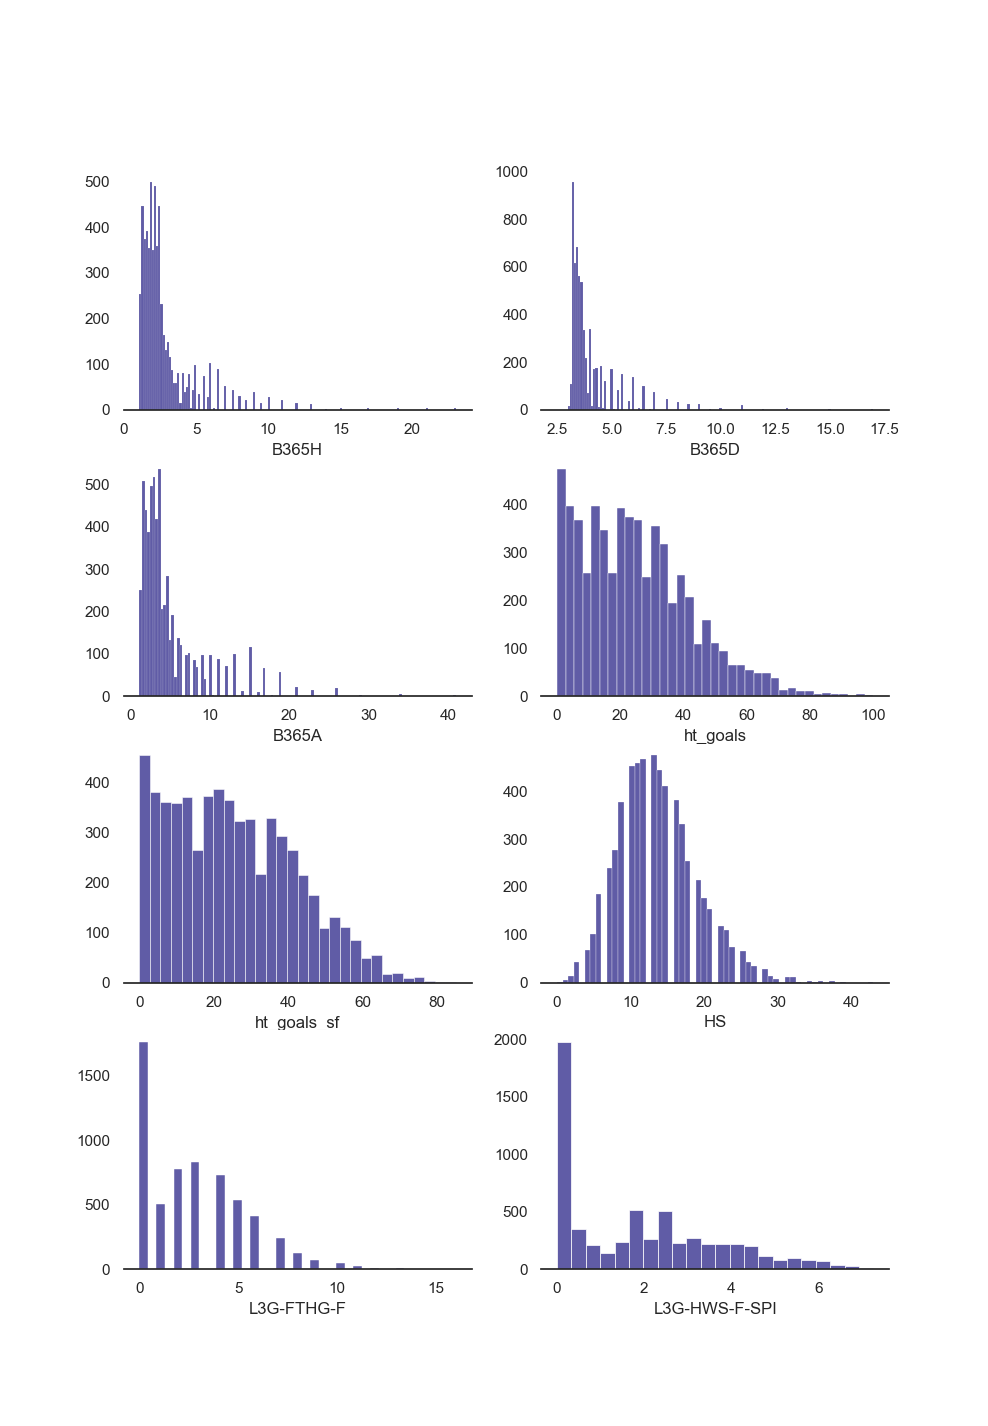

In [363]:
import seaborn as sns
color = sns.color_palette("CMRmap")
sns.set(rc={'figure.figsize':(5,5)},palette = color, style = 'white')
visualize_cols = ['B365H','B365D','B365A','ht_goals','ht_goals_sf','HS','L3G-FTHG-F','L3G-HWS-F-SPI']

plt.figure()
for i, column in enumerate(visualize_cols, 1):
    try:
        plt.subplot(4,2,i)
        
        sns.histplot(df_in[column]).set(ylabel = None)
        sns.despine(left=True)
    except:
        pass

<IPython.core.display.Javascript object>


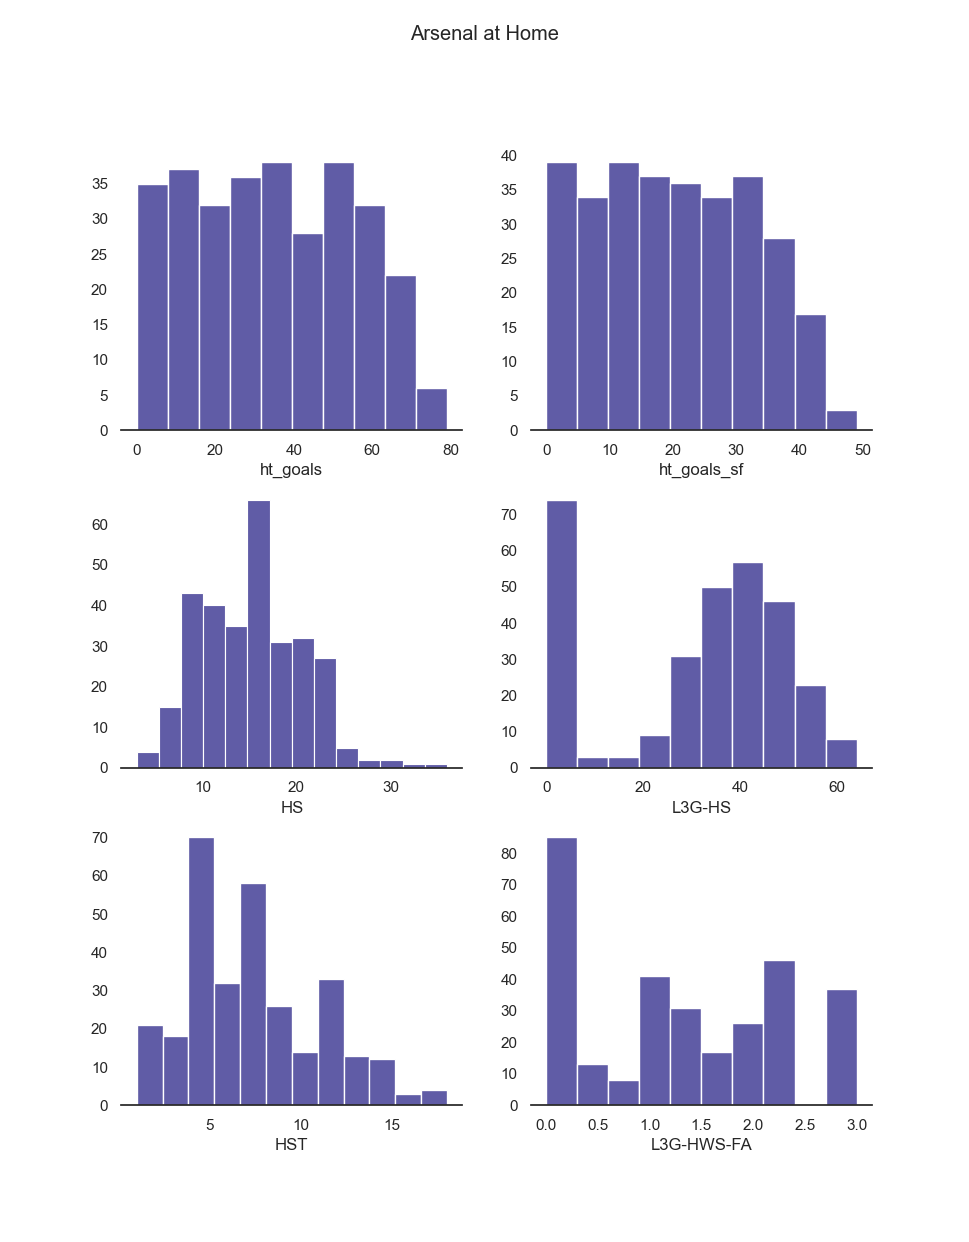

In [364]:
df_ar_h = df_in.loc[(df_in['HomeTeam'] =='Arsenal')]
club_cols_h = ['ht_goals','ht_goals_sf','HS','L3G-HS','HST','L3G-HWS-FA']

plt.figure()
for i, column in enumerate(club_cols_h, 1):
    try:
        plt.subplot(3,2,i)
        plt.suptitle("Arsenal at Home")
        sns.histplot(df_ar_h[column]).set(ylabel = None)
        sns.despine(left=True)
    except:
        pass

<IPython.core.display.Javascript object>


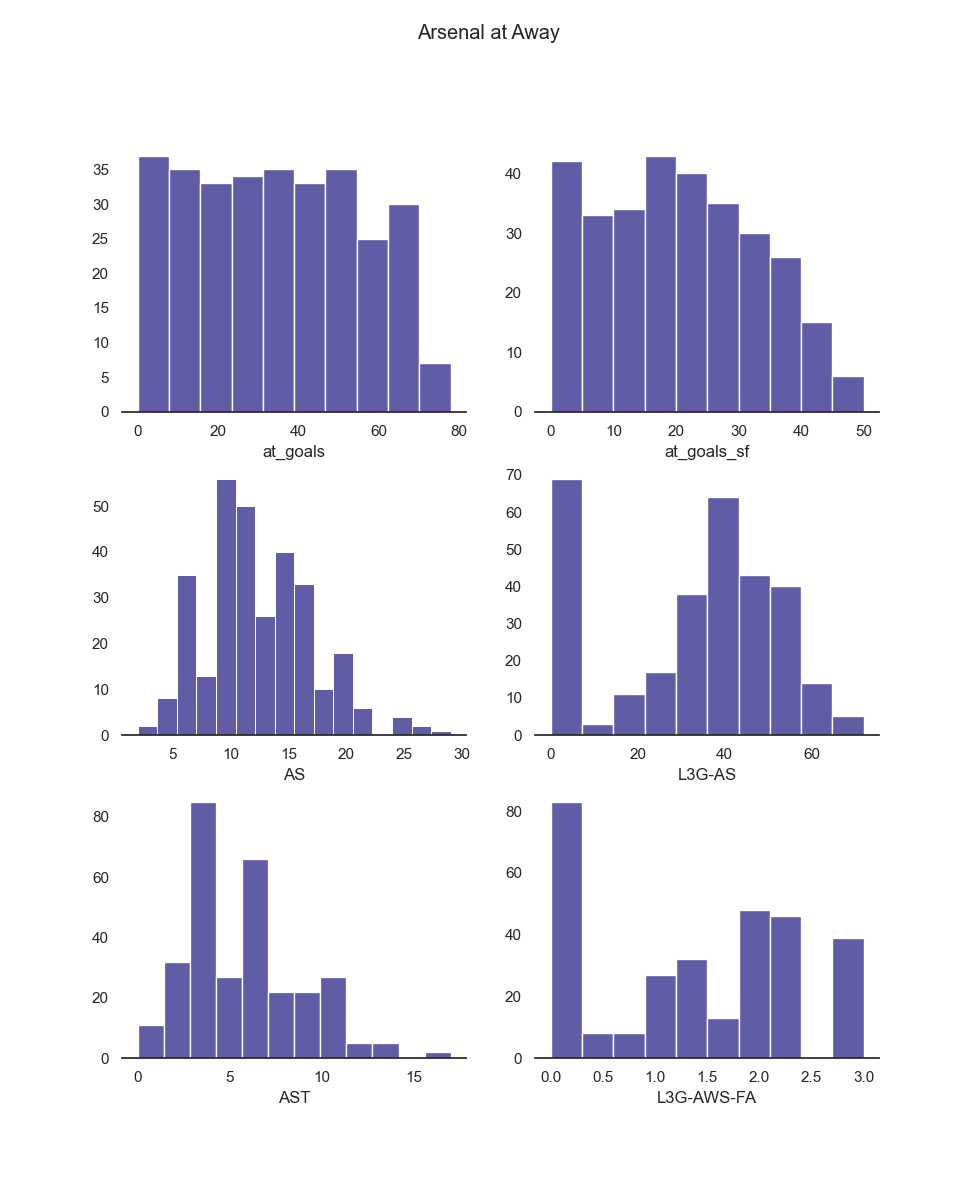

In [365]:
df_ar_a = df_in.loc[(df_in['AwayTeam'] =='Arsenal')]
club_cols_a = ['at_goals','at_goals_sf','AS','L3G-AS','AST','L3G-AWS-FA']

plt.figure()
for i, column in enumerate(club_cols_a, 1):
    try:
        plt.subplot(3,2,i)
        plt.suptitle("Arsenal at Away")
        sns.histplot(df_ar_a[column]).set(ylabel = None)
        sns.despine(left=True)
    except:
        pass

<IPython.core.display.Javascript object>


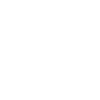

<IPython.core.display.Javascript object>


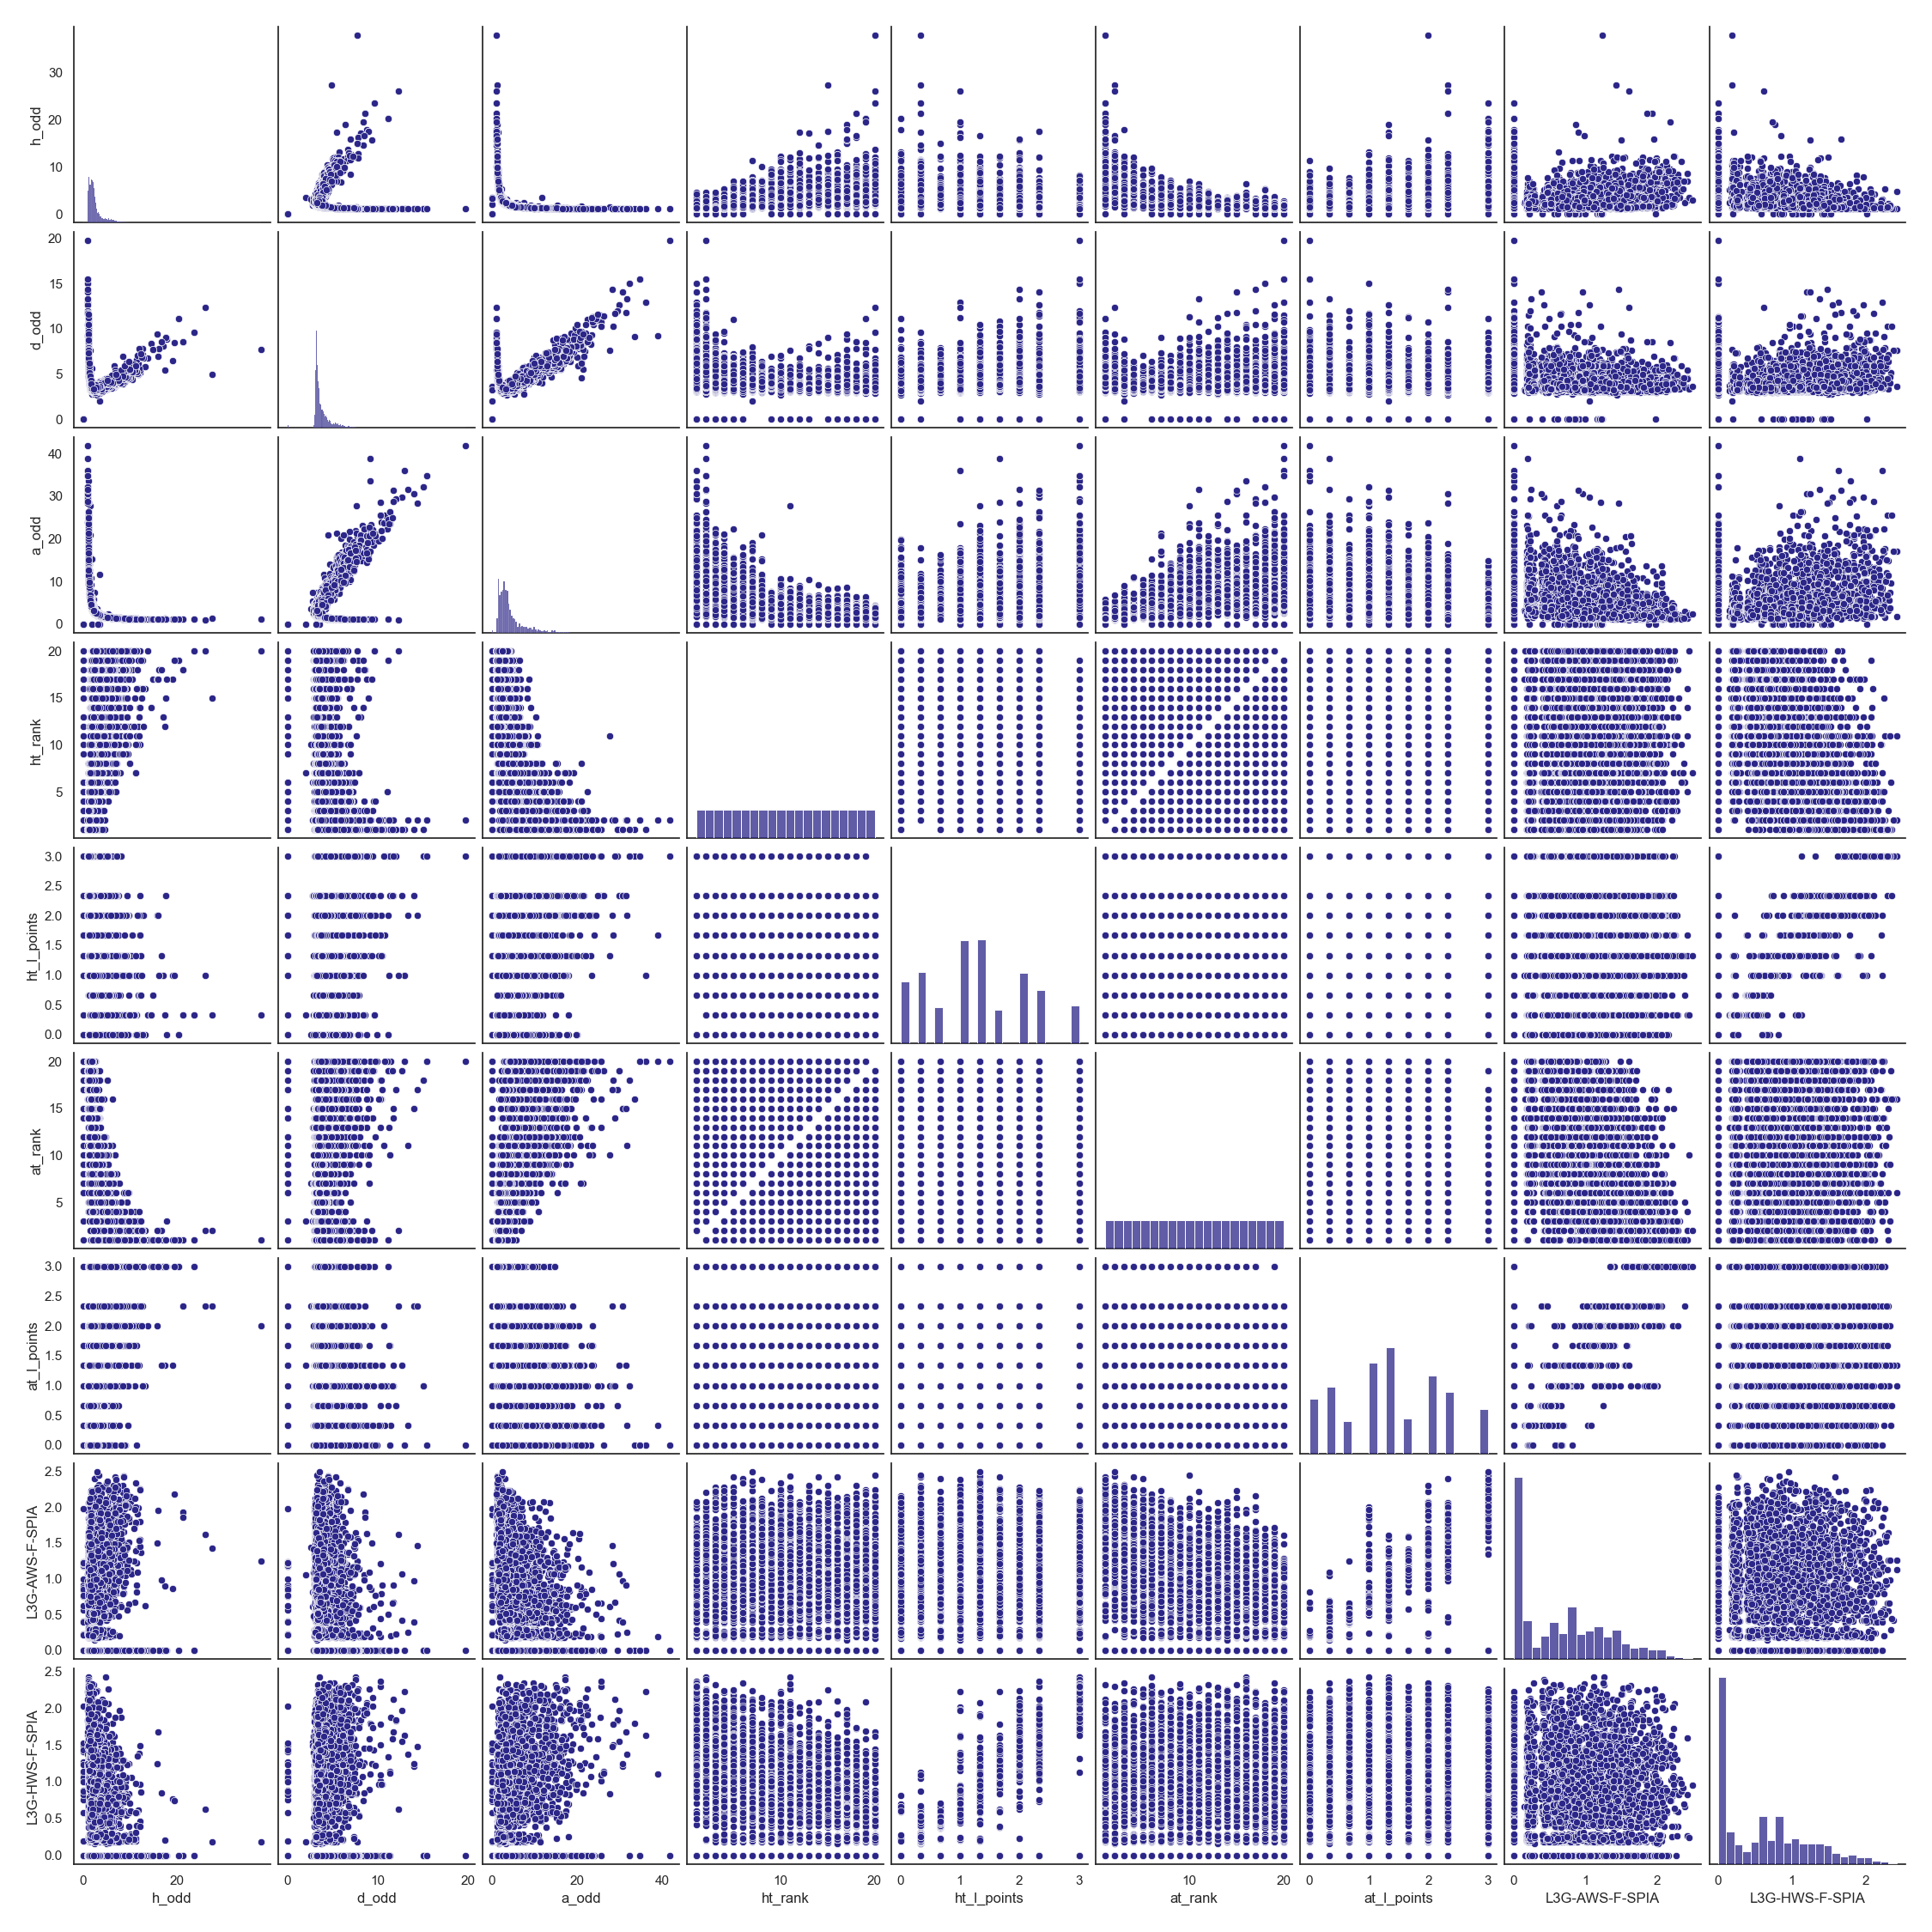

In [374]:
color = sns.color_palette("CMRmap")

sns.set(palette = color, style = 'white')

plt.figure()
sns.pairplot(df_in[['h_odd',
 'd_odd',
 'a_odd',
 'ht_rank',
 'ht_l_points',
 'at_rank',
 'at_l_points',
 'L3G-AWS-F-SPIA',
 'L3G-HWS-F-SPIA']])



for ax in g.axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.labelpad = 100   

In [421]:
# df_in['Bookie_Pred'] = 1
# df_in.loc[(df_in['B365A'] > df_in['B365H']) , 'Bookie_Pred'] = 2
# df_in.loc[(df_in['B365H'] > df_in['B365A']) , 'Bookie_Pred'] = 0

#populating bookie's predictions
final_data['Bookie_Pred'] = 1
final_data.loc[(df_in['B365A'] > final_data['B365H']) , 'Bookie_Pred'] = 2
final_data.loc[(df_in['B365H'] > final_data['B365A']) , 'Bookie_Pred'] = 0

df_in[['FTR','B365H','B365D','B365A','Bookie_Pred']].head(10)

,FTR,B365H,B365D,B365A,Bookie_Pred
5697,1,2.30,3.25,3.00,2
5698,0,5.00,3.40,1.72,0
5699,1,2.37,3.25,2.87,2
5700,1,1.72,3.40,5.00,2
5701,1,2.87,3.20,2.40,0
5702,0,2.75,3.20,2.50,0
5703,0,2.37,3.20,2.90,2
5704,2,2.50,3.20,2.75,2
5705,2,1.40,4.20,8.00,2
5706,0,10.00,4.50,1.33,0


In [422]:
# % of matches bookies predict correctly
sum(list(final_data['Bookie_Pred']==df_in['FTR']))/len(df_in['FTR'])*100

54.74740826065493

# Training Models

### 1. SVM

In [423]:
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler #because data are not normally distributed

In [455]:
#test-train split after scaling
X = final_data
y = final_result
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [457]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)
# svm_model.fit(X_train_scaled, y_train)
# svm_model.score(X_test_scaled, y_test)

0.5633223684210527

C:\Users\saimo\.conda\envs\cse6363\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


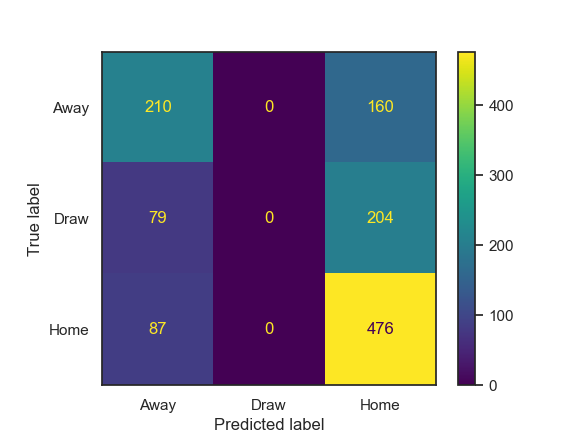

In [436]:
plot_confusion_matrix(svm_model,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Away','Draw','Home'])

In [463]:
param_grid = [{
    'C':[6,7,8],
    'gamma': [0.00002,0.00003,0.00005],
    'kernel': ['rbf']
}]

optimal_params = GridSearchCV(SVC(),
                              param_grid,
                              cv=5,
                              scoring='accuracy')

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'C': 8, 'gamma': 5e-05, 'kernel': 'rbf'}


In [462]:
svm_model_optimized = SVC(kernel='rbf', C=8, gamma=0.00005)
svm_model_optimized.fit(X_train, y_train)
svm_model_optimized.score(X_test, y_test)

0.569078947368421

C:\Users\saimo\.conda\envs\cse6363\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


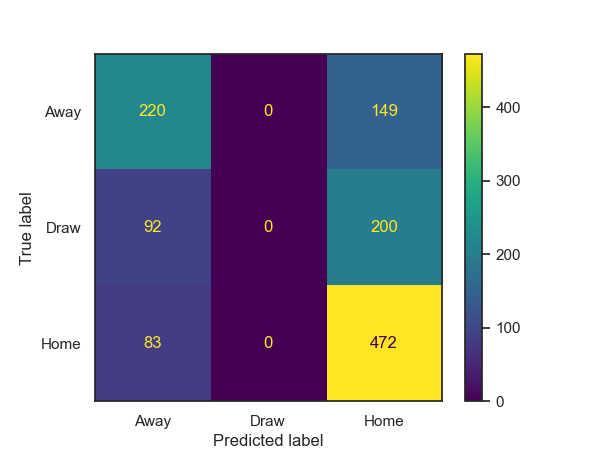

In [464]:
plot_confusion_matrix(svm_model_optimized,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Away','Draw','Home'])

### 2. XGBoost 

In [474]:
# !pip install xgboost
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer

In [476]:
y.value_counts()

2    2805
0    1816
1    1456
Name: FTR, dtype: int64

In [484]:
#train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)
# X_train = scale(X_train)
# X_test = scale(X_test)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [485]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', early_stopping_rounds=10, seed=42)
xgb_model.fit(X_train,
              y_train,
              verbose=True,
              eval_set=[(X_test, y_test)]) #evaluating how many trees to build using testing dataset

[0]	validation_0-aucpr:0.51975
[1]	validation_0-aucpr:0.51851
[2]	validation_0-aucpr:0.52472
[3]	validation_0-aucpr:0.52363
[4]	validation_0-aucpr:0.53125
[5]	validation_0-aucpr:0.53455
[6]	validation_0-aucpr:0.53527
[7]	validation_0-aucpr:0.53844
[8]	validation_0-aucpr:0.53944
[9]	validation_0-aucpr:0.54011
[10]	validation_0-aucpr:0.54094
[11]	validation_0-aucpr:0.54310
[12]	validation_0-aucpr:0.54396
[13]	validation_0-aucpr:0.54401
[14]	validation_0-aucpr:0.54499
[15]	validation_0-aucpr:0.54666
[16]	validation_0-aucpr:0.54659
[17]	validation_0-aucpr:0.54541
[18]	validation_0-aucpr:0.54546
[19]	validation_0-aucpr:0.54536
[20]	validation_0-aucpr:0.54749
[21]	validation_0-aucpr:0.54698
[22]	validation_0-aucpr:0.55044
[23]	validation_0-aucpr:0.55191
[24]	validation_0-aucpr:0.55169
[25]	validation_0-aucpr:0.55008
[26]	validation_0-aucpr:0.54893
[27]	validation_0-aucpr:0.54952
[28]	validation_0-aucpr:0.55140
[29]	validation_0-aucpr:0.55087
[30]	validation_0-aucpr:0.55158
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

C:\Users\saimo\.conda\envs\cse6363\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


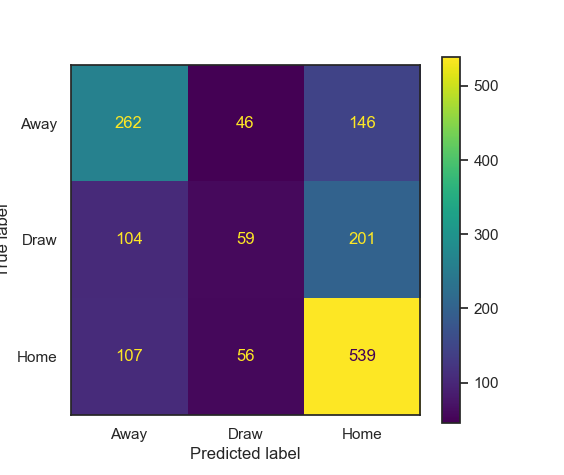

In [486]:
plot_confusion_matrix(xgb_model,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Away','Draw','Home'])

In [504]:
#Round 1
param_grid = {'max_depth': [1],
             'learning_rate': [0.00005,0.0001],
             'gamma': [0],
             'reg_lambda': [0],
             'scale_pos_weight': [1]}
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                  seed=42,
                                  subsample=0.9,
                                  colsample_bytree=0.5,
                                  early_stopping_rounds=10,
                                  eval_metric='auc'),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=10,
    cv=5)

optimal_params.fit(X_train,
              y_train,
              verbose=True,
              eval_set=[(X_test, y_test)])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[20:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.68182
[1]	validation_0-auc:0.69373
[2]	validation_0-auc:0.69313
[3]	validation_0-auc:0.69344
[4]	validation_0-auc:0.69716
[5]	validation_0-auc:0.69702
[6]	validation_0-auc:0.69904
[7]	validation_0-auc:0.69892
[8]	validation_0-auc:0.69907
[9]	validation_0-auc:0.69923
[10]	validation_0-auc:0.69913
[11]	validation_0-auc:0.69883
[12]	validation_0-auc:0.69918
[13]	validation_0-auc:0.69979
[14]	validation_0-auc:0.69969


C:\Users\saimo\.conda\envs\cse6363\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan]
  category=UserWarning,


[15]	validation_0-auc:0.70016
[16]	validation_0-auc:0.69998
[17]	validation_0-auc:0.70011
[18]	validation_0-auc:0.70014
[19]	validation_0-auc:0.69988
[20]	validation_0-auc:0.69991
[21]	validation_0-auc:0.69985
[22]	validation_0-auc:0.69992
[23]	validation_0-auc:0.69987
[24]	validation_0-auc:0.69992


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [505]:
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 5e-05, 'max_depth': 1, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [514]:
xgb_model_optimized = xgb.XGBClassifier(objective='binary:logistic',
                                        eval_metric='aucpr',
                                        early_stopping_rounds=10,
                                        seed=42,
                                        gamma= 0,
                                        learning_rate= 1,
                                        max_depth= 1,
                                        reg_lambda= 0,
                                        scale_pos_weight= 1)
xgb_model_optimized.fit(X_train,
              y_train,
              verbose=True,
              eval_set=[(X_test, y_test)]) #evaluating how many trees to build using testing dataset

[20:03:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.49660
[1]	validation_0-aucpr:0.51272
[2]	validation_0-aucpr:0.52648
[3]	validation_0-aucpr:0.53274
[4]	validation_0-aucpr:0.54173
[5]	validation_0-aucpr:0.54702
[6]	validation_0-aucpr:0.54726
[7]	validation_0-aucpr:0.54358
[8]	validation_0-aucpr:0.54555
[9]	validation_0-aucpr:0.54896
[10]	validation_0-aucpr:0.55017
[11]	validation_0-aucpr:0.54885
[12]	validation_0-aucpr:0.54717
[13]	validation_0-aucpr:0.54617
[14]	validation_0-aucpr:0.54446
[15]	validation_0-aucpr:0.54393
[16]	validation_0-aucpr:0.54387
[17]	validation_0-aucpr:0.54074
[18]	vali

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=1,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, ...)

C:\Users\saimo\.conda\envs\cse6363\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>


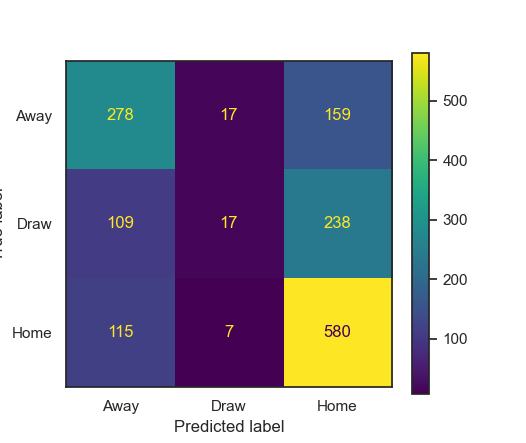

In [545]:
plot_confusion_matrix(xgb_model_optimized,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Away','Draw','Home'])

In [557]:
dfs1[1][['ht_ls_rank','spi1','ht_rank']].head(20)

,ht_ls_rank,spi1,ht_rank
0,4,84.723848,3
1,8,66.535197,7
2,11,76.983956,6
3,7,63.140911,13
4,17,65.486549,9
5,20,64.772194,8
6,20,54.415339,18
7,9,58.920000,15
8,1,86.321818,2
9,2,84.825455,1
